In [1]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import pandas as pd
import bioread
from scipy.fft import fft, fftfreq,ifft
from scipy import signal
from scipy.signal import find_peaks

In [2]:
def vent(vent_name,M):
    nw = np.arange(2*M+1)
    if vent_name == 'rectangular':
        ventana = np.piecewise(nw,nw>=0,[1,0])
    elif vent_name == 'hanning':
        ventana = 0.5*(1+np.cos(2*np.pi*(nw-M)/(2*M+1)))
    elif vent_name == 'hamming':
        ventana = 0.54+0.46*np.cos(2*np.pi*(nw-M)/(2*M+1))
    elif vent_name == 'blackman':
        ventana = 0.42+0.5*np.cos(2*np.pi*(nw-M)/(2*M+1))+0.08*np.cos(4*np.pi*(nw-M)/(2*M+1))
    return np.vstack((nw,ventana)).T

In [3]:
def Hvent(w,ventana):
    z = 0
    for k in np.arange(len(ventana)):
        z = z + ventana[k]*np.exp(-1j*w*k)
    aux = z
    return np.vstack((w,abs(aux),np.angle(aux))).T

In [4]:
def FIR(nombreArchivo):
    ECG = bioread.read_file (nombreArchivo)
    t = ECG.time_index.T

    señal = ECG.channels[0].data

    N = len(señal)
    Fs = ECG.channels[0].samples_per_second
    
    # Elimino tendencia -----------------------------------------------------------------------------
    A3 = np.arange(0,N,250) #arreglo
    B3 = tuple(A3) #tupla
    señal = signal.detrend(señal,bp=A3)
    #------------------------------------------------------------------------------------------------


    espectro = fft(señal)/N
    w = np.linspace(0,2*np.pi,N)
    eje_f = w*Fs/(2*np.pi)

        
#------Analizo el espectro entre los 40 y 65 Hz
    f_min = np.where(eje_f>40)
    f_max = np.where((eje_f>40)&(eje_f<65))
    
    f_m = f_min[0][0] #frecuencia mínima de analisis
    f_M = f_max[0][len(f_max[0])-1] #frecuencia máxima de análisis
    
    #...Determino cual es el valor de mi frecuencia de ruido...    
    vm = np.where(abs(espectro)[f_m:f_M]==np.max(abs(espectro)[f_m:f_M]))
    f_r = eje_f[f_m+vm[0][0]] #frecuencia de ruido
    
    #...Determino los valores de frecuencias de corte
    
    fc1 = (f_r - 5);    fc2 = (f_r + 5)
    
    wc1 = 2*np.pi*fc1/Fs;    wc2 = 2*np.pi*fc2/Fs
    
#...Coeficientes de pasa banda ideal.....
    n_f = np.arange(-500, 500, dtype=float)
    
    h_bs = np.piecewise(n_f, [n_f == 0],[lambda n_f: 1-(wc2-wc1)/np.pi,
                                         lambda n_f: -(np.sin(wc2*n_f)-np.sin(wc1*n_f))/(np.pi*n_f)])

    ventana_nombre = 'rectangular'
    M = [40,80,200,400] #---Semiancho de las ventanas
    
    Mejores_S = []; Mejor_SNR = []
    #Para cada tipo de ventana elijo la mejor señal de acuerdo a la SNR
    señales = []
    SNRs = []
    for j in range(len(M)):
        m = M[j]
        vent_BP = vent(ventana_nombre,m)
#......desplazo los coeficientes
        n_desp = np.arange(2*m+1,dtype=float)
        h_desp = np.piecewise(n_desp, [n_desp == m],[lambda n_desp: 1-(wc2-wc1)/np.pi,
                                             lambda n_desp: -(np.sin(wc2*(n_desp-m))-np.sin(wc1*(n_desp-m)))/(np.pi*(n_desp-m))])
        Hw2 = 0
        for i in range(len(n_desp)):
            Hw2 = Hw2 + (vent_BP[:,1][i] * h_desp[i]* np.exp(-1j*w*n_desp[i]))
            
        señal_filtrada = signal.lfilter(vent_BP[:,1]*h_desp, 1,señal)
            
        #Analisis de atenuacion
        peaks_max_signal = find_peaks(señal,distance=500)[0];peaks_min_signal = find_peaks(-señal,distance=500)[0]
        A_max_signal = np.mean(señal[peaks_max_signal]) ; A_min_signal = np.mean(señal[peaks_min_signal])

        peaks_max = find_peaks(señal_filtrada,distance=500)[0]
        peaks_min = find_peaks(-señal_filtrada,distance=500)[0]
        A_max = np.mean(señal_filtrada[peaks_max]) ; A_min = np.mean(señal_filtrada[peaks_min])

        A_signal = A_max_signal - A_min_signal ; A_signal_filtr = A_max - A_min
        Atenuac = np.round (abs((A_signal - A_signal_filtr)*100/A_signal),1)

        ### Ruido
        max_noise = max(señal_filtrada[0:200]) #ruido uniforme en toda la señal
        min_noise = min(señal_filtrada[0:200])
        A_noise = max_noise - min_noise
        SNR = A_signal_filtr / A_noise
        SNR_dB = 20*np.log (A_signal_filtr/A_noise)
            
        señales.append([ventana_nombre,m*2,señal_filtrada])
        SNRs.append([ventana_nombre,m*2,SNR,SNR_dB,Atenuac])
          
    #Elijo las señales con atenuacion <20%
    valores_atenuac = np.zeros(len(M))
    for k in range(len(M)):
        valores_atenuac[k]= SNRs[k][4]            
    mf = np.where((valores_atenuac<20))
    
    L1_snr = []; L2_signal = []
    for i in range(len(mf[0])):
        L1_snr.append(SNRs[i])
        L2_signal.append(señales[i])
            
    Mejores_S.append(L2_signal); Mejor_SNR.append(L1_snr)
    
    #De las señales obtenidas, determino la que tiene mayor relacion SNR
    valores_SNR = []
    for i in range(len(Mejor_SNR[0])):   
        valores_SNR.append(Mejor_SNR[0][i][2])
        
    mK = np.where(valores_SNR==np.max(valores_SNR))
    MEJOR_SEÑAL_data = Mejores_S[0][mK[0][0]] 
    MEJOR_SEÑAL_SNR = Mejor_SNR[0][mK[0][0]]

   
    plt.figure(figsize=(20,4),dpi=600)
    plt.plot(t,señal,'r')
    plt.plot(t, MEJOR_SEÑAL_data[2], 'b')
    plt.legend(('señal original',('Filtrado con ',MEJOR_SEÑAL_data[0],'orden',MEJOR_SEÑAL_data[1],'')))
    plt.xlabel('t [seg]', fontsize=12)
    plt.grid (True)
    #plt.savefig('imagenes/senal.jpg', dpi=600, bbox_inches='tight')
    plt.show()
    
    print('SNR:', MEJOR_SEÑAL_SNR[3],'dB')
    print('Atenuacion:', MEJOR_SEÑAL_SNR[4],'%')

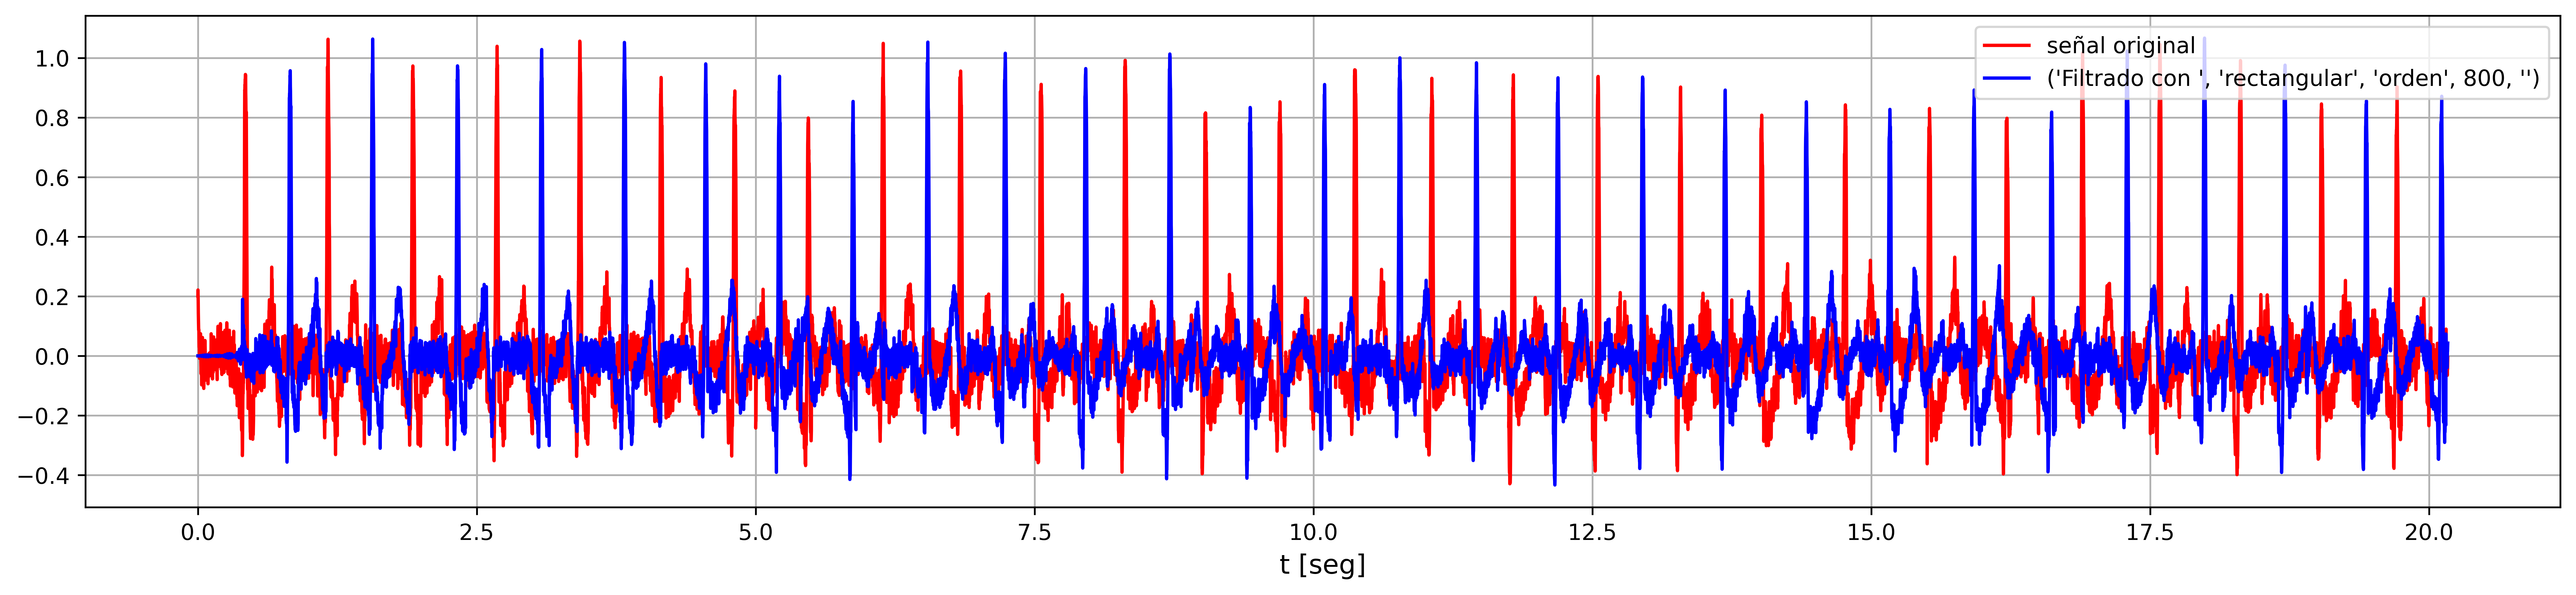

SNR: 104.81242551554664 dB
Atenuacion: 1.9 %


In [5]:
FIR("/Users/paulaaguirrecarol/Desktop/Copia de 2. ecg_sinf.acq")